In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import bz2
from scipy import ndimage

reading file


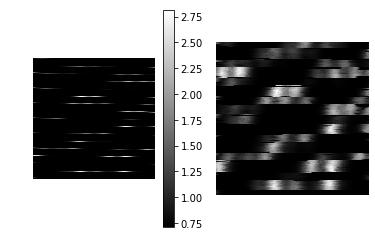

In [11]:
# Read data
print('reading file')
image = loadFromQ2bz('/srv/home/chenyu/JDDC/DistortionCheck/exp_1us/AsymmetricModel/bump-0_003.q2bz')
defX = loadFromQ2bz("/srv/home/chenyu/JDDC/DistortionCheck/exp_1us/AsymmetricModel/bump-0_003-y_0.q2bz")
defY = loadFromQ2bz("/srv/home/chenyu/JDDC/DistortionCheck/exp_1us/AsymmetricModel/bump-0_003-y_1.q2bz")

deformed_image = deformImage(image, defX, defY, order=1, mode='nearest')

# Save and display the result
# imageio.imwrite("deformed_image.png", deformed_image)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.colorbar()
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deformed_image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [3]:
def loadFromQ2bz(path):
    filename, file_extension = os.path.splitext(path)

    if(file_extension == '.q2bz' or file_extension == '.bz2'):
        fid = bz2.open(path, 'rb')
    else:
        fid = open(path, 'rb')
    # Read magic number
    line = fid.readline().rstrip().decode('ascii')
    if(line[0] != 'P'):
        quit("Invalid array header, doesn't start with 'P'")
    if(line[1] != '9'):
        quit("Invalid data type, only double is supported currently")
    fid.readline().rstrip()  # Skip header

    # Read width and height
    arr = fid.readline().rstrip().split()
    width = int(arr[0])
    height = int(arr[1])

    # Read max, but be careful not to read more than one new line after max.
    # The binary data could start with a value that is equivalent to a
    # new line.
    max = ""
    while True:
        c = fid.read(1)
        if c == b'\n':
            break
        max = max + str(int(c))

    max = int(max)

    # Read image to vector
    x = np.frombuffer(fid.read(), np.float64)
    img = x.reshape(width, height)
    return img

In [4]:
def deformImage(image, displacementX, displacementY, order=1, mode='nearest', cval=0.0):
    # Convert the displacement to a coordinate system
    coords = np.mgrid[0:image.shape[0], 0:image.shape[1]] \
             + np.multiply([displacementY, displacementX], (np.max(image.shape)-1))

    # Resample the image at the coordinates obtained from the displacement to deform the image
    return ndimage.map_coordinates(image, coords, order=order, mode=mode, cval=cval)